In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.apache.hadoop:hadoop-aws:2.7.0,"
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 6]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [5]:
keof = {}

In [6]:
from cov import cov11


@f.udf(ArrayType(DoubleType()))
def extract_ke(arr):
    return [
        d["C1p"]["ke"] if ("C1p" in d) and (d["C1p"]["pz"] < 0) else np.nan
        for d in arr
    ]


keof["C1p"] = cov11(
    df.select(
        extract_ke("hits.as_").alias("ke"),
        f.col("hits.t").alias("t"),
    ),
    "ke", "t",
)

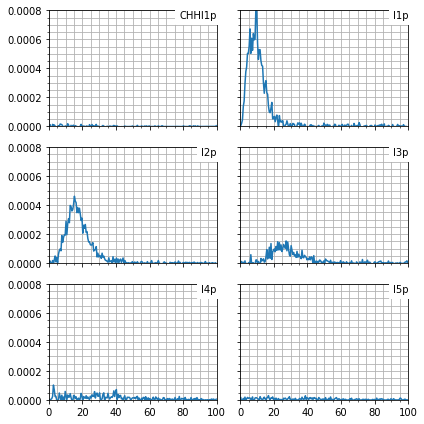

In [8]:
ke = keof["C1p"]
fr, to, nbins = 0, 100, 200
kbins = np.linspace(fr, to, nbins + 1)
x = (kbins[1:] + kbins[:-1]) / 2

plt.figure(figsize=(6, 6))
for i, (k, (fr1, to1)) in enumerate([
        ("CHHI1p", [5400, 5600]),
        ("I1p", [5200, 5400]),
        ("I2p", [3800, 4000]),
        ("I3p", [3200, 3400]),
        ("I4p", [2800, 3000]),
        ("I5p", [2630, 2780]),
        ]):
    plt.subplot(3, 2, i + 1)
    plt.text(1, 1, k,
             horizontalalignment="right",
             verticalalignment="top",
             transform=plt.gca().transAxes,
             bbox={"facecolor": "w", "edgecolor": "w"})
    y = ke(
        fr, to, nbins, fr1, to1,
    )["Cov[X,Y]"][..., 0]
    plt.plot(x, y)
    plt.xlim(0, 100)
    plt.ylim(0, 8e-4)
    plt.minorticks_on()
    plt.grid(True, which="both")
    plt.gca().label_outer()

plt.tight_layout()
plt.savefig("Figures/aq035--aq036; C1p KE covariant with TOF.pdf")
plt.show()

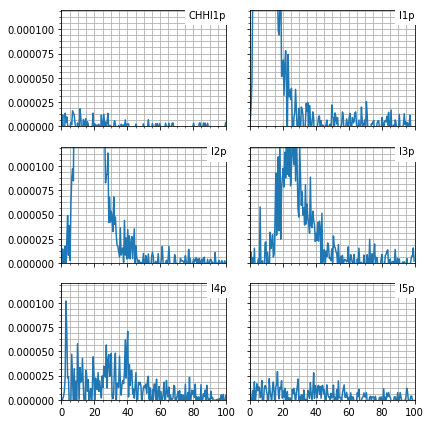

In [12]:
ke = keof["C1p"]
fr, to, nbins = 0, 100, 200
kbins = np.linspace(fr, to, nbins + 1)
x = (kbins[1:] + kbins[:-1]) / 2

plt.figure(figsize=(6, 6))
for i, (k, (fr1, to1)) in enumerate([
        ("CHHI1p", [5400, 5600]),
        ("I1p", [5200, 5400]),
        ("I2p", [3800, 4000]),
        ("I3p", [3200, 3400]),
        ("I4p", [2800, 3000]),
        ("I5p", [2630, 2780]),
        ]):
    plt.subplot(3, 2, i + 1)
    plt.text(1, 1, k,
             horizontalalignment="right",
             verticalalignment="top",
             transform=plt.gca().transAxes,
             bbox={"facecolor": "w", "edgecolor": "w"})
    y = ke(
        fr, to, nbins, fr1, to1,
    )["Cov[X,Y]"][..., 0]
    plt.plot(x, y)
    plt.xlim(0, 100)
    plt.ylim(0, 1.2e-4)
    plt.minorticks_on()
    plt.grid(True, which="both")
    plt.gca().label_outer()

plt.tight_layout()
plt.savefig("Figures/aq035--aq036; C1p KE covariant with TOF; Expanded.pdf")
plt.show()

In [9]:
from cov import cov11


@f.udf(ArrayType(DoubleType()))
def extract_ke(arr):
    return [
        d["C2p"]["ke"] if "C2p" in d else np.nan
        for d in arr
    ]


keof["C2p"] = cov11(
    df.select(
        extract_ke("hits.as_").alias("ke"),
        f.col("hits.t").alias("t"),
    ),
    "ke", "t",
)

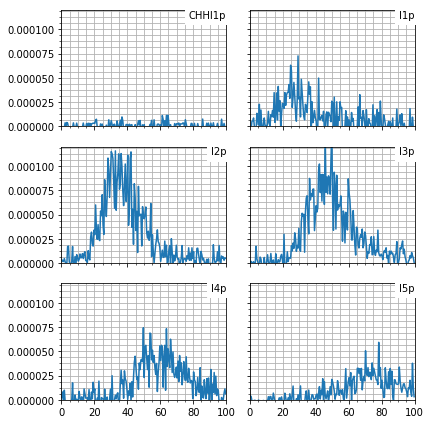

In [10]:
ke = keof["C2p"]
fr, to, nbins = 0, 100, 200
kbins = np.linspace(fr, to, nbins + 1)
x = (kbins[1:] + kbins[:-1]) / 2

plt.figure(figsize=(6, 6))
for i, (k, (fr1, to1)) in enumerate([
        ("CHHI1p", [5400, 5600]),
        ("I1p", [5200, 5400]),
        ("I2p", [3800, 4000]),
        ("I3p", [3200, 3400]),
        ("I4p", [2800, 3000]),
        ("I5p", [2630, 2780]),
        ]):
    plt.subplot(3, 2, i + 1)
    plt.text(1, 1, k,
             horizontalalignment="right",
             verticalalignment="top",
             transform=plt.gca().transAxes,
             bbox={"facecolor": "w", "edgecolor": "w"})
    y = ke(
        fr, to, nbins, fr1, to1,
    )["Cov[X,Y]"][..., 0]
    plt.plot(x, y)
    plt.xlim(0, 100)
    plt.ylim(0, 1.2e-4)
    plt.minorticks_on()
    plt.grid(True, which="both")
    plt.gca().label_outer()

plt.tight_layout()
plt.savefig("Figures/aq035--aq036; C2p KE covariant with TOF.pdf")
plt.show()